# DATA ANALYSIS PIPELINE

This notebook outlines a comprehensive data analysis pipeline on a real-world dataset. You can download the dataset from:
[Telco Customer Churn Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

## Dataset Overview

The Telco Customer Churn dataset captures customer demographics, account information, and service usage for a telecom provider.

## Objective

The primary goal of this Data Analysis is to ensure that we get a thorough understanding of the data and insights, and that we are using the most relevant features for building a performant machine learning model.

## Proposed Data Analysis Pipeline

The proposed Data Analysis Pipeline consists of the following steps:

1. **Data Ingestion & Initial Cleaning**: Loading the data and performing initial cleaning to handle missing values, duplicates, and inconsistencies.
2. **Exploratory Data Analysis (EDA)**: Exploring the data to understand its structure, distributions, and relationships between variables.
3. **Recursive Feature Elimination (RFE) & Dimensionality Reduction (PCA)**: Selecting the most relevant features and reducing dimensionality to improve model performance.

This workflow is well-structured and logical for this dataset, ensuring a thorough understanding of the data and the use of the most relevant features to build a performant ML model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# If working in Google Colab, upload the downloaded data
from google.colab import files
uploaded = files.upload()

Saving Telco_Customer_Churn.csv to Telco_Customer_Churn (2).csv


### 1.2 Get to know your data


In [3]:
# Load the dataset
df = pd.read_csv('/content/Telco_Customer_Churn.csv')

# Display the first 3 rows of the dataframe
df.head(3)

# Display basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 



The results show 100% non-null values. However, `df.info()` may report 100% non-null even though some fields could contain blanks.

Therefore, to properly assess missingness, we need to identify the string columns that could contain blanks:


In [4]:
obj_cols = df.select_dtypes(include='object').columns

df[obj_cols] = df[obj_cols].applymap(lambda x: np.nan if isinstance(x, str) and x.strip()=="" else x)


/tmp/ipython-input-437695020.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[obj_cols] = df[obj_cols].applymap(lambda x: np.nan if isinstance(x, str) and x.strip()=="" else x)


In [5]:
#Check again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The only column with missing values is TotalCharges, which has 11 nulls

In [6]:
#Check number of distinct values
df['TotalCharges'].nunique()

6530

### Interpretation:

There are categorical variables that are binary (Yes/No) and some with low cardinality. For example, 'TotalCharges' has **7032 non-null** entries, **6530 unique values**, and **11 null values**. This indicates that 'TotalCharges' is likely a numerical feature that has some missing entries. Thus, we'll convert 'TotalCharges' to numeric and handle the missing values appropriately:


In [7]:
#convert to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

### Imputation of remaining nulls:

The only column has missing values is TotalCharges:

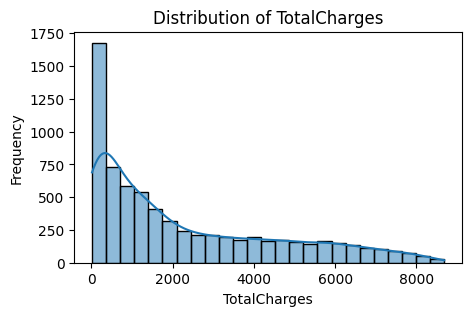

In [8]:
# Check the distribution of 'TotalCharges'
plt.figure(figsize=(5, 3))
sns.histplot(df['TotalCharges'], kde=True)
plt.title('Distribution of TotalCharges')
plt.xlabel('TotalCharges')
plt.ylabel('Frequency')
plt.show()


### Interpretation

Data is skewed (not normally distributed)-->  median for imputing missing values is a better measure of central tendency because it is less affected by outliers:

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy ="median")
df["TotalCharges"] = imputer.fit_transform(df[["TotalCharges"]])

In [10]:
# Verify that there are no more missing values
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### Target variable "Churn":

A binary, with counts showing an imbalance in the data:

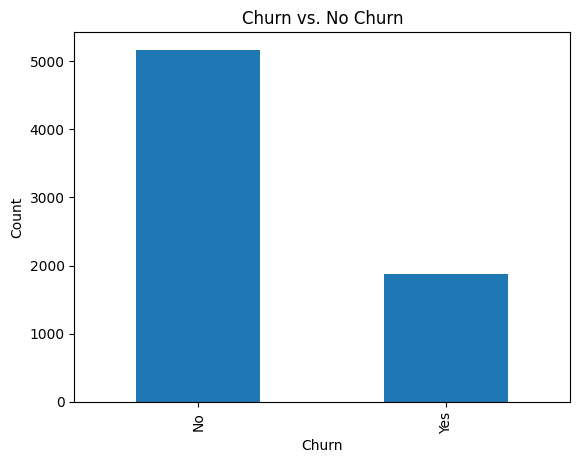

In [11]:
df['Churn'].value_counts().plot(kind='bar', title='Churn vs. No Churn')
plt.ylabel('Count')
plt.show()

In [12]:
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

### Interpretation

We'll created a new binary target variable 'ChurnFlag' where 'Yes' is encoded as 1 and 'No' as 0. We then dropped the original 'Churn' column and the 'customerID' column, as it does not add any predictive value to the model.

This ensures that the dataset is clean and ready for further analysis or modeling, with a clear binary target variable and unnecessary columns removed.

In [13]:
# Drop 'customerID' columns
df.drop('customerID', axis=1, inplace=True)

# Verify the changes
print(df.columns)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [14]:
#Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns
cat_cols = categorical_cols.to_list()
cat_cols


['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [15]:
from sklearn.preprocessing import OneHotEncoder

# Convert binary features
binary_columns = [col for col in cat_cols if df[col].nunique() == 2]
for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})  # Adjust mapping as needed


# One-hot encoding for 3-category and 4-category features
three_category_cols = [col for col in cat_cols if df[col].nunique() == 3]
four_category_cols = [col for col in cat_cols if df[col].nunique() == 4]

# Combine the lists of 3- and 4- category features for one-hot encoding
all_categorical_cols = three_category_cols + four_category_cols

# Initialize the OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid dummy variable trap

# Fit and transform the categorical columns
ohe_arr = ohe.fit_transform(df[all_categorical_cols])
ohe_cols = ohe.get_feature_names_out(all_categorical_cols)
df_ohe = pd.DataFrame(ohe_arr, columns=ohe_cols, index=df.index)

# Convert one-hot encoded columns to integer type
df_ohe = df_ohe.astype(int)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([df.drop(columns=all_categorical_cols), df_ohe], axis=1)

# Check the final DataFrame
print(df.head())
print(df.dtypes)


   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0                0                                0                0   
1                0                    

### Numeric Conversion

This dataset has a large number of categorical variables.

It therefore advisable to convert categorical variables to a numeric format before conducting univariate analysis. This ensures that all relevant features are included in the descriptive statistics and that we can accurately assess their distributions.

Since our dataset contains only binary variables, as well as categorical variables with 3 or 4 unique values, we'll adopt the following structured approach to convert these variables appropriately:

- Convert Binary Features using mapping to convert binary features to numeric (0 and 1)

- Using One-Hot Encoding for 3-Category and 4-Category Features. Since OneHotEncoder returns float by default, we'll convert them explicitly to int after encoding.

**Note:** I'll be using this Data Analysis to build a Random Forest model and use Logistic Regression for feature selection with Recursive Feature Elimination (RFE). Therefore, I can keep all categories. While I can still use drop='first' for Random Forest, it is not strictly necessary. Random Forest can handle multicollinearity well, so you may choose to keep all categories if you believe it will provide more information for the model.


After cleaning and converting categorical features to numeric - see table below for a more detailed description:



| Feature                                  | Description                                                                 |
|------------------------------------------|-----------------------------------------------------------------------------|
| **Gender**                               | Binary indicator (0 or 1) representing the gender of the customer.         |
| **SeniorCitizen**                        | Binary indicator (0 or 1) representing whether a customer is a senior citizen. |
| **Partner**                             | Binary indicator (0 or 1) representing whether a customer has a partner.   |
| **Dependents**                           | Binary indicator (0 or 1) representing whether a customer has dependents.  |
| **Tenure**                               | Number of months a customer has been with the service.                     |
| **PhoneService**                         | Binary indicator (0 or 1) representing whether a customer has phone service. |
| **PaperlessBilling**                     | Binary indicator (0 or 1) representing whether a customer opts for paperless billing. |
| **MonthlyCharges**                       | Monthly fee charged to the customer for the service.                       |
| **TotalCharges**                         | Total amount charged to the customer over their entire tenure.             |
| **MultipleLines_No phone service**       | Binary indicator (0 or 1) representing customers without phone service.     |
| **MultipleLines_Yes**                    | Binary indicator (0 or 1) representing customers who have multiple lines.   |
| **InternetService_Fiber optic**          | Binary indicator (0 or 1) representing whether a customer has fiber optic internet service. |
| **InternetService_No**                    | Binary indicator (0 or 1) representing whether a customer has no internet service. |
| **OnlineSecurity_No internet service**    | Binary indicator (0 or 1) representing customers without internet service for online security. |
| **OnlineSecurity_Yes**                    | Binary indicator (0 or 1) representing customers who have online security.  |
| **OnlineBackup_No internet service**      | Binary indicator (0 or 1) representing customers without internet service for online backup. |
| **OnlineBackup_Yes**                      | Binary indicator (0 or 1) representing customers who have online backup.    |
| **DeviceProtection_No internet service**  | Binary indicator (0 or 1) representing customers without internet service for device protection. |
| **DeviceProtection_Yes**                  | Binary indicator (0 or 1) representing customers who have device protection. |
| **TechSupport_No internet service**       | Binary indicator (0 or 1) representing customers without internet service for tech support. |
| **TechSupport_Yes**                       | Binary indicator (0 or 1) representing customers who have tech support.     |
| **StreamingTV_No internet service**       | Binary indicator (0 or 1) representing customers without internet service for streaming TV. |
| **StreamingTV_Yes**                       | Binary indicator (0 or 1) representing customers who use streaming TV services. |
| **StreamingMovies_No internet service**    | Binary indicator (0 or 1) representing customers without internet service for streaming movies. |
| **StreamingMovies_Yes**                   | Binary indicator (0 or 1) representing customers who use streaming movies.   |
| **Contract_One year**                     | Binary indicator (0 or 1) representing customers on a one-year contract.    |
| **Contract_Two year**                     | Binary indicator (0 or 1) representing customers on a two-year contract.    |
| **PaymentMethod_Credit card (automatic)** | Binary indicator (0 or 1) representing customers using automatic credit card payments. |
| **PaymentMethod_Electronic check**        | Binary indicator (0 or 1) representing customers using electronic checks.    |
| **PaymentMethod_Mailed check**            | Binary indicator (0 or 1) representing customers using mailed checks.        |

# 2. Exploratory Data Analysis (EDA)

## 2.1 Summary Statistics:


In [16]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
gender,7043.0,0.504756,0.500013,0.00,0.000,1.000,1.00,1.00
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.000,0.000,0.00,1.00
Partner,7043.0,0.483033,0.499748,0.00,0.000,0.000,1.00,1.00
Dependents,7043.0,0.299588,0.458110,0.00,0.000,0.000,1.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.000,55.00,72.00
PhoneService,7043.0,0.903166,0.295752,0.00,1.000,1.000,1.00,1.00
PaperlessBilling,7043.0,0.592219,0.491457,0.00,0.000,1.000,1.00,1.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.85,118.75
TotalCharges,7043.0,2281.916928,2265.270398,18.80,402.225,1397.475,3786.60,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.000,0.000,1.00,1.00


### Interpretation


1. **SeniorCitizen** feature is a binary variable:
   - **0**: Represents customers who are **not** senior citizens.
   - **1**: Represents customers who **are** senior citizens.
   - **Mean**: A mean of **0.16** indicates that approximately **16%** of the customers are senior citizens. Since mean is the sum of all values divided by the count of values. For a binary variable (0 and 1), it can be interpreted as the proportion of occurrences of the value **1**.
   - **Distribution & Quartile Values of SeniorCitizen**:
     - The **25%**, **50%**, and **75%** quartile values being **0** indicates that at least **75%** of the customers in the dataset are not senior citizens.
     - Additionally, since only **16%** of the customers are senior citizens, the remaining **84%** of customers (those with a value of **0**) are not senior citizens.
   - This means that the majority of customers fall into the **0** category. This indicates a customer base that is predominantly younger, with senior citizens representing a smaller segment of the overall population.

2. **Tenure**:
   - **Mean**: A mean tenure of **32.37** months suggests that, on average, customers stay with the service for about **2.7 years**.
   - **Range**: The minimum tenure is **0 months** (new customers), while the maximum is **72 months** (6 years), indicates a diverse range of customer loyalty.

3. **MonthlyCharges**:
   - **Mean**: The average monthly charge is **€64.76**, with a standard deviation of **€30.09**, indicating variability in pricing.
   - **Range**: Monthly charges range from **€18.25** to **€118.75**, suggesting different service plans or features.

4. **TotalCharges**:
   - **Mean**: The average total charges amount to **€2283.30**, reflecting the cumulative spending of customers over their tenure.
   - **Range**: Total charges range from **€18.80** to **€8684.80**, indicating that some customers have been with the service for a long time and have accumulated higher charges.

5. **gender**:
   - **0**: Represents female customers.
   - **1**: Represents male customers.
   - **Mean**: A mean of **0.50** indicates that approximately **50%** of the customers are male.
   - **Distribution & Quartile Values of gender**:
     - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates that the gender distribution is nearly equal.
   - This means that the dataset is balanced in terms of gender representation.

6. **Partner**:
   - **0**: Represents customers who do not have a partner.
   - **1**: Represents customers who have a partner.
   - **Mean**: A mean of **0.48** indicates that approximately **48%** of the customers have a partner.
   - **Distribution & Quartile Values of Partner**:
     - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without partners.
   - This means that the dataset is nearly balanced in terms of partner status.

7. **Dependents**:
   - **0**: Represents customers who do not have dependents.
   - **1**: Represents customers who have dependents.
   - **Mean**: A mean of **0.30** indicates that approximately **30%** of the customers have dependents.
   - **Distribution & Quartile Values of Dependents**:
     - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers do not have dependents.
   - This means that the majority of customers do not have dependents.

8. **PhoneService**:
   - **0**: Represents customers who do not have phone service.
   - **1**: Represents customers who have phone service.
   - **Mean**: A mean of **0.90** indicates that approximately **90%** of the customers have phone service.
   - **Distribution & Quartile Values of PhoneService**:
     - The **25%**, **50%**, and **75%** quartile values being **1** indicates that a majority of customers have phone service.
   - This means that almost all customers have phone service.


9. **PaperlessBilling**:
   - **0**: Represents customers who do not have paperless billing.
   - **1**: Represents customers who have paperless billing.
   - **Mean**: A mean of **0.59** indicates that approximately **59%** of the customers have paperless billing.
   - **Distribution & Quartile Values of PaperlessBilling**:
     - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without paperless billing.
   - This means that the dataset is nearly balanced in terms of paperless billing adoption.

10. **MultipleLines_No phone service**:
    - **0**: Represents customers who do not have multiple lines and do not have phone service.
    - **1**: Represents customers who have multiple lines and do not have phone service.
    - **Mean**: A mean of **0.097** indicates that approximately **9.7%** of the customers have multiple lines but do not have phone service.
    - **Distribution & Quartile Values of MultipleLines_No phone service**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers do not have multiple lines and do not have phone service.
    - This means that the majority of customers do not fall into this category.

11. **MultipleLines_Yes**:
    - **0**: Represents customers who do not have multiple lines.
    - **1**: Represents customers who have multiple lines.
    - **Mean**: A mean of **0.422** indicates that approximately **42.2%** of the customers have multiple lines.
    - **Distribution & Quartile Values of MultipleLines_Yes**:
      - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without multiple lines.
    - This means that the dataset is nearly balanced in terms of multiple lines adoption.

12. **InternetService_Fiber optic**:
    - **0**: Represents customers who do not have fiber optic internet service.
    - **1**: Represents customers who have fiber optic internet service.
    - **Mean**: A mean of **0.440** indicates that approximately **44.0%** of the customers have fiber optic internet service.
    - **Distribution & Quartile Values of InternetService_Fiber optic**:
      - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without fiber optic internet service.
    - This means that the dataset is nearly balanced in terms of fiber optic internet service adoption.

13. **InternetService_No**:
    - **0**: Represents customers who have internet service.
    - **1**: Represents customers who do not have internet service.
    - **Mean**: A mean of **0.217** indicates that approximately **21.7%** of the customers do not have internet service.
    - **Distribution & Quartile Values of InternetService_No**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers have internet service.
    - This means that the majority of customers have internet service.

14. **OnlineSecurity_No internet service**:
    - **0**: Represents customers who have online security and have internet service.
    - **1**: Represents customers who do not have online security and do not have internet service.
    - **Mean**: A mean of **0.217** indicates that approximately **21.7%** of the customers do not have online security and do not have internet service.
    - **Distribution & Quartile Values of OnlineSecurity_No internet service**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers have online security and have internet service.
    - This means that the majority of customers have online security and have internet service.

15. **OnlineSecurity_Yes**:
    - **0**: Represents customers who do not have online security.
    - **1**: Represents customers who have online security.
    - **Mean**: A mean of **0.287** indicates that approximately **28.7%** of the customers have online security.
    - **Distribution & Quartile Values of OnlineSecurity_Yes**:
      - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without online security.
    - This means that the dataset is nearly balanced in terms of online security adoption.

16. **OnlineBackup_No internet service**:
    - **0**: Represents customers who have online backup and have internet service.
    - **1**: Represents customers who do not have online backup and do not have internet service.
    - **Mean**: A mean of **0.217** indicates that approximately **21.7%** of the customers do not have online backup and do not have internet service.
    - **Distribution & Quartile Values of OnlineBackup_No internet service**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers have online backup and have internet service.
    - This means that the majority of customers have online backup and have internet service.

17. **OnlineBackup_Yes**:
    - **0**: Represents customers who do not have online backup.
    - **1**: Represents customers who have online backup.
    - **Mean**: A mean of **0.345** indicates that approximately **34.5%** of the customers have online backup.
    - **Distribution & Quartile Values of OnlineBackup_Yes**:
      - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without online backup.
    - This means that the dataset is nearly balanced in terms of online backup adoption.

18. **DeviceProtection_No internet service**:
    - **0**: Represents customers who have device protection and have internet service.
    - **1**: Represents customers who do not have device protection and do not have internet service.
    - **Mean**: A mean of **0.217** indicates that approximately **21.7%** of the customers do not have device protection and do not have internet service.
    - **Distribution & Quartile Values of DeviceProtection_No internet service**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers have device protection and have internet service.
    - This means that the majority of customers have device protection and have internet service.

19. **DeviceProtection_Yes**:
    - **0**: Represents customers who do not have device protection.
    - **1**: Represents customers who have device protection.
    - **Mean**: A mean of **0.344** indicates that approximately **34.4%** of the customers have device protection.
    - **Distribution & Quartile Values of DeviceProtection_Yes**:
      - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without device protection.
    - This means that the dataset is nearly balanced in terms of device protection adoption.

20. **TechSupport_No internet service**:
    - **0**: Represents customers who have tech support and have internet service.
    - **1**: Represents customers who do not have tech support and do not have internet service.
    - **Mean**: A mean of **0.217** indicates that approximately **21.7%** of the customers do not have tech support and do not have internet service.
    - **Distribution & Quartile Values of TechSupport_No internet service**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers have tech support and have internet service.
    - This means that the majority of customers have tech support and have internet service.

21. **TechSupport_Yes**:
    - **0**: Represents customers who do not have tech support.
    - **1**: Represents customers who have tech support.
    - **Mean**: A mean of **0.290** indicates that approximately **29.0%** of the customers have tech support.
    - **Distribution & Quartile Values of TechSupport_Yes**:
      - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without tech support.
    - This means that the dataset is nearly balanced in terms of tech support adoption.

22. **StreamingTV_No internet service**:
    - **0**: Represents customers who have streaming TV and have internet service.
    - **1**: Represents customers who do not have streaming TV and do not have internet service.
    - **Mean**: A mean of **0.217** indicates that approximately **21.7%** of the customers do not have streaming TV and do not have internet service.
    - **Distribution & Quartile Values of StreamingTV_No internet service**:
      - The **25%**, **50%**, and **75%** quartile values being **0

      23. **StreamingTV_Yes**:
    - **0**: Represents customers who do not have streaming TV.
    - **1**: Represents customers who have streaming TV.
    - **Mean**: A mean of **0.384** indicates that approximately **38.4%** of the customers have streaming TV.
    - **Distribution & Quartile Values of StreamingTV_Yes**:
      - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without streaming TV.
    - This means that the dataset is nearly balanced in terms of streaming TV adoption.

24. **StreamingMovies_No internet service**:
    - **0**: Represents customers who have streaming movies and have internet service.
    - **1**: Represents customers who do not have streaming movies and do not have internet service.
    - **Mean**: A mean of **0.217** indicates that approximately **21.7%** of the customers do not have streaming movies and do not have internet service.
    - **Distribution & Quartile Values of StreamingMovies_No internet service**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers have streaming movies and have internet service.
    - This means that the majority of customers have streaming movies and have internet service.

25. **StreamingMovies_Yes**:
    - **0**: Represents customers who do not have streaming movies.
    - **1**: Represents customers who have streaming movies.
    - **Mean**: A mean of **0.388** indicates that approximately **38.8%** of the customers have streaming movies.
    - **Distribution & Quartile Values of StreamingMovies_Yes**:
      - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers with and without streaming movies.
    - This means that the dataset is nearly balanced in terms of streaming movies adoption.

26. **Contract_One year**:
    - **0**: Represents customers who do not have a one-year contract.
    - **1**: Represents customers who have a one-year contract.
    - **Mean**: A mean of **0.209** indicates that approximately **20.9%** of the customers have a one-year contract.
    - **Distribution & Quartile Values of Contract_One year**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers do not have a one-year contract.
    - This means that the majority of customers do not have a one-year contract.

27. **Contract_Two year**:
    - **0**: Represents customers who do not have a two-year contract.
    - **1**: Represents customers who have a two-year contract.
    - **Mean**: A mean of **0.241** indicates that approximately **24.1%** of the customers have a two-year contract.
    - **Distribution & Quartile Values of Contract_Two year**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers do not have a two-year contract.
    - This means that the majority of customers do not have a two-year contract.

28. **PaymentMethod_Credit card (automatic)**:
    - **0**: Represents customers who do not use credit card (automatic) as their payment method.
    - **1**: Represents customers who use credit card (automatic) as their payment method.
    - **Mean**: A mean of **0.216** indicates that approximately **21.6%** of the customers use credit card (automatic) as their payment method.
    - **Distribution & Quartile Values of PaymentMethod_Credit card (automatic)**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers do not use credit card (automatic) as their payment method.
    - This means that the majority of customers do not use credit card (automatic) as their payment method.

29. **PaymentMethod_Electronic check**:
    - **0**: Represents customers who do not use electronic check as their payment method.
    - **1**: Represents customers who use electronic check as their payment method.
    - **Mean**: A mean of **0.336** indicates that approximately **33.6%** of the customers use electronic check as their payment method.
    - **Distribution & Quartile Values of PaymentMethod_Electronic check**:
      - The **25%**, **50%**, and **75%** quartile values being **0** and **1** indicates a nearly equal split between customers who use and do not use electronic check as their payment method.
    - This means that the dataset is nearly balanced in terms of electronic check usage for payments.

30. **PaymentMethod_Mailed check**:
    - **0**: Represents customers who do not use mailed check as their payment method.
    - **1**: Represents customers who use mailed check as their payment method.
    - **Mean**: A mean of **0.229** indicates that approximately **22.9%** of the customers use mailed check as their payment method.
    - **Distribution & Quartile Values of PaymentMethod_Mailed check**:
      - The **25%**, **50%**, and **75%** quartile values being **0** indicates that a majority of customers do not use mailed check as their payment method.
    - This means that the majority of customers do not use mailed check as their payment method.

**In summary**:
- The dataset includes a mix of binary, categorical, and continuous features.
- There is a nearly equal split between genders and a significant proportion of customers with partners and dependents.
- Tenure and charges show high variability, indicating a diverse customer base.
- Most customers have phone service and paperless billing.
- The dataset is nearly balanced in terms of various service adoptions like multiple lines, fiber optic internet, online security, online backup, device protection, tech support, streaming TV, and streaming movies.
- Contract types and payment methods show varied adoption rates, with electronic check being the most commonly used payment method.




## 2.2 Univariate Analysis

### Skewness & Kurtosis


In [17]:
print("Skewness:\n", df.skew())
print("Kurtosis:\n", df.kurtosis())

Skewness:
 gender                                  -0.019031
SeniorCitizen                            1.833633
Partner                                  0.067922
Dependents                               0.875199
tenure                                   0.239540
PhoneService                            -2.727153
PaperlessBilling                        -0.375396
MonthlyCharges                          -0.220524
TotalCharges                             0.963789
Churn                                    1.063031
MultipleLines_No phone service           2.727153
MultipleLines_Yes                        0.316610
InternetService_Fiber optic              0.243494
InternetService_No                       1.375769
OnlineSecurity_No internet service       1.375769
OnlineSecurity_Yes                       0.943722
OnlineBackup_No internet service         1.375769
OnlineBackup_Yes                         0.652817
DeviceProtection_No internet service     1.375769
DeviceProtection_Yes                   

### Explaination


###Skewness:

Skewness is a statistical measure that quantifies the asymmetry of a distribution.

The formula for sample skewness:

$$
\text{Skewness} = \frac{n}{(n-1)(n-2)} \sum \left( \frac{x_i - \bar{x}}{s} \right)^3
$$

where:
-  n  = number of observations
- $x_i$ = each individual observation
- $\bar{x}$ = mean of the observations
- $ s = \sqrt{\frac{1}{n-1} \sum (x_i - \bar{x})^2}$ is standard deviation of the observation.

###Kurtosis:

Kurtosis is a statistical measure that quantifies the "tailedness" of a distribution.

The formula for sample kurtosis:

$$
\text{Kurtosis} = \frac{n(n+1)}{(n-1)(n-2)(n-3)} \sum \left( \frac{x_i - \bar{x}}{s} \right)^4 - \frac{3(n-1)^2}{(n-2)(n-3)}
$$

where:
-  n  = number of observations
- $x_i$ = each individual observation
- $\bar{x}$ = mean of the observations
- $ s = \sqrt{\frac{1}{n-1} \sum (x_i - \bar{x})^2}$ is standard deviation of the observation.

___

### Implications of Positive Skewness

Positive skewness indicates that the tail on the right side of the distribution is longer or fatter than the left side. Here are some implications and considerations for positively skewed data:

- **Mean > Median**: In a positively skewed distribution, the mean is typically greater than the median. This is because the mean is more influenced by the extreme values in the tail of the distribution.
- **Right-Tailed Distribution**: The distribution has a longer right tail, which means there are more outliers on the right side.
- **Data Transformation**: When analyzing positively skewed data, it may be useful to consider transformations (like logarithmic or square root transformations) to normalize the data for certain statistical analyses.
- **Interpretation**: Positive skewness can indicate the presence of a few very high values that pull the mean upwards, while the majority of the data points are concentrated on the left side of the distribution.
- **Statistical Tests**: Some statistical tests and models assume normality and may not be appropriate for positively skewed data without transformation.


------
### Implications of Negative Skewness

Negative skewness indicates that the tail on the left side of the distribution is longer or fatter than the right side. Here are some implications and considerations for negatively skewed data:

- **Mean < Median**: In a negatively skewed distribution, the mean is typically less than the median. This is because the mean is pulled downwards by the extreme values in the left tail of the distribution.
- **Left-Tailed Distribution**: The distribution has a longer left tail, which means there are more outliers on the left side.
- **Data Transformation**: When analyzing negatively skewed data, it may be useful to consider transformations (like logarithmic or square root transformations) to normalize the data for certain statistical analyses.
- **Interpretation**: Negative skewness can indicate the presence of a few very low values that pull the mean downwards, while the majority of the data points are concentrated on the right side of the distribution.
- **Statistical Tests**: Some statistical tests and models assume normality and may not be appropriate for negatively skewed data without transformation.

----------
### Implications of Kurtosis

Kurtosis measures the "tailedness" of the probability distribution of a real-valued random variable. Here are the implications of different kurtosis values:

- **Leptokurtic (Kurtosis > 3)**: The distribution has fatter tails and a sharper peak than the normal distribution. This indicates a higher probability of outliers.
- **Mesokurtic (Kurtosis ≈ 3)**: The distribution has tails and a peak similar to the normal distribution. This is the baseline for comparison.
- **Platykurtic (Kurtosis < 3)**: The distribution has thinner tails and a flatter peak than the normal distribution. This indicates a lower probability of outliers.

Kurtosis is used in risk management, as it provides insights into the likelihood of extreme events. For example, in finance, leptokurtic distributions are often associated with higher risk due to the increased likelihood of extreme price movements.


### Visualization of Distribution of Data

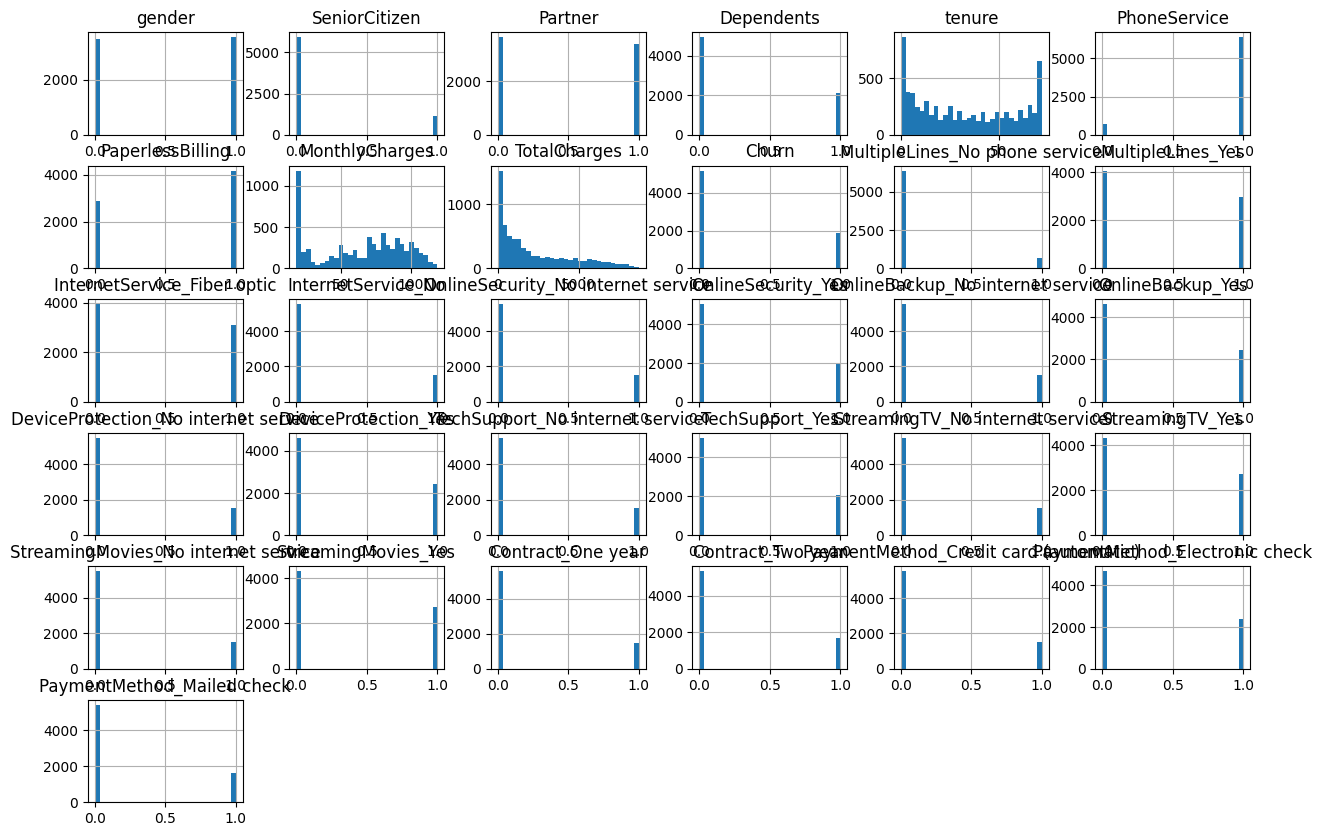

In [18]:
df.hist(bins=30, figsize=(15,10))
plt.show()


### Interpretation of Histograms with Skewness and Kurtosis:


#### 1. **Tenure**

The **Tenure** histogram shows a U-shaped distribution with peaks at both ends, indicating a high number of new and long-term customers, and fewer customers with moderate tenure.

**Skewness and Kurtosis**:
- **Skewness**: 0.239540 (slightly right-skewed)
- **Kurtosis**: -1.387372 (platykurtic, flatter distribution)

**Implications**:
- **New Customers**: The high number of new customers suggests effective acquisition strategies but may raise retention concerns. The slight right skewness supports this interpretation, indicating a longer tail on the right side with fewer long-term customers.
- **Long-Term Customers**: Fewer long-term customers indicate potential retention issues or high satisfaction among those who stay. The platykurtic distribution suggests a flatter peak, meaning fewer customers fall into the moderate tenure range.
- **Churn Insights**: New customers may have higher churn rates, while long-term customers are likely more loyal. The U-shaped distribution and skewness imply that customer churn is influenced by tenure.
- **Strategies**: Target new customers with engagement campaigns and incentivize long-term customers to enhance loyalty.

**Summary**: A U-shaped histogram for **Tenure** indicates a strong presence of new customers and a relatively lower number of long-term customers. This suggests successful customer acquisition but potential challenges in long-term retention. The skewness and kurtosis values support the interpretation of a flatter distribution with fewer customers in the moderate tenure range. Further analysis of churn rates and customer feedback can provide insights into improving retention strategies.

#### 2. **MonthlyCharges**

The **MonthlyCharges** histogram shows a left-skewed distribution, with many customers paying lower monthly fees.

**Skewness and Kurtosis**:
- **Skewness**: -0.220524 (slightly left-skewed)
- **Kurtosis**: -1.257260 (platykurtic, flatter distribution)

**Implications**:
- **Price Sensitivity**: Many customers are on budget-friendly plans, indicating price sensitivity. The slight left skewness confirms that the majority of customers are paying lower monthly charges.
- **Premium Plans**: Fewer customers are willing to pay higher monthly charges. The platykurtic distribution suggests a flatter peak, meaning fewer customers fall into the higher charge categories.
- **Strategies**: Develop targeted campaigns to encourage upgrades to higher-tier plans and implement retention strategies for customers on lower plans.

**Summary**: The histogram for **MonthlyCharges** indicates that many customers are on lower-tier plans, suggesting price sensitivity. The skewness and kurtosis values support the interpretation of a flatter distribution with fewer customers in the higher charge categories. This distribution highlights the importance of targeted strategies to enhance customer retention and encourage upgrades to higher-tier services.

#### 3. **TotalCharges**

The **TotalCharges** histogram is right-skewed, with most customers having lower cumulative charges and a few having significantly higher charges.

**Skewness and Kurtosis**:
- **Skewness**: 0.963789 (right-skewed)
- **Kurtosis**: -0.226400 (mesokurtic, similar to a normal distribution)

**Implications**:
- **Customer Segmentation**: Most customers have lower total charges, possibly due to shorter tenures or lower-tier plans. The right skewness confirms that the majority of customers have lower cumulative charges. The mesokurtic distribution suggests a peak similar to a normal distribution, with a few outliers on the right side.
- **High-Value Customers**: A few customers have high total charges, indicating long-term or high-spending customers. These high-value customers significantly contribute to overall revenue.
- **Churn Considerations**: Customers with lower total charges may be at higher risk of churn. Understanding the reasons behind churn in this segment can help improve retention strategies.
- **Revenue Implications**: High-value customers significantly contribute to overall revenue. The right skewness highlights the importance of retaining and nurturing these high-value customers.
- **Strategies**: Implement loyalty programs for long-term customers and target lower-spending customers with upgrade offers.

**Summary**: The right-skewed histogram for **TotalCharges** indicates that while most customers have lower cumulative charges, a few high-value customers significantly contribute to overall revenue. The skewness and kurtosis values support the interpretation of a distribution with a few outliers on the right side. This distribution highlights the importance of understanding customer behavior across different segments and developing targeted strategies to enhance retention and maximize revenue. Further analysis of customer feedback and churn rates can provide additional insights into improving customer satisfaction and loyalty.

## Boxplots

Boxplots provide an excellent way to visualize the distribution of continuous data and identify potential outliers. They are particularly useful for understanding the spread, central tendency, and potential outliers in a dataset. However, boxplots are not typically relevant for binary variables, as they do not have a meaningful distribution in the same sense as continuous variables. For binary variables, other types of visualizations such as bar plots or pie charts are more appropriate.

**Box**:

The box itself represents the IQR (Interquartile Range), which is the range between Q1 and Q3. It contains the middle 50% of the data. A larger IQR indicates more variability in the data.

- **Q1 (First Quartile)**: This is the 25th percentile of the data. It marks the point below which 25% of the data falls. The left edge of the box represents Q1.
- **Q3 (Third Quartile)**: This is the 75th percentile of the data. It marks the point below which 75% of the data falls. The right edge of the box represents Q3.
- **Median**: The line inside the box represents the median (Q2), which is the 50th percentile of the data. This line divides the box into two parts, showing where half of the data points lie below and half lie above.

**Whiskers**: Lines extended from the box to the smallest and largest values within 1.5 times the IQR from the quartiles. Whisker and Min/Max value Relationship:

  - If $ \text{minimum} \geq Q1 - 1.5 \times \text{IQR} $, the lower whisker extends up to the minimum value, in which case, the lower whisker and the minimum are equal.
  - Likewise, if $\text{maximum} \leq Q3 + 1.5 \times \text{IQR}$, the upper whisker extends to the maximum value, in which case, the upper whisker and the maximum value are equal.

**Outliers** occur when:
  - The minimum value is less than the lower whisker threshold, and/or
  - The maximum value is greater than the upper whisker threshold.

Outliers are data points that fall outside the range defined by the whiskers in a boxplot. They are typically represented as individual points (often marked with circles) and indicate unusual observations in the dataset.

**What to look for in a Boxplot**:

- **Outliers**: Identify any outliers that may indicate unusual customer behavior or data entry errors.
- **Distribution Shape**: Observe the symmetry of the box. A box that is not centered may indicate skewness in the data.

## Data Distribution for Binary Variables:

### 1. **SeniorCitizen**
- **Histogram Description**: The histogram displays two bars: **0** (not senior citizens) and **1** (senior citizens). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that the majority of customers are not senior citizens. This confirms that the customer base is predominantly younger or middle-aged.

---

### 2. **Partner**
- **Histogram Description**: The histogram shows two bars: **0** (no partner) and **1** (has a partner). The height of each bar represents the count of customers in each category.
- **Interpretation**: The distribution is balanced between customers with and without partners, indicating a mix of single and partnered customers in the dataset.

---

### 3. **Dependents**
- **Histogram Description**: The histogram displays two bars: **0** (no dependents) and **1** (has dependents). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is taller than the bar for **1**, indicating that more customers do not have dependents. This suggests that a significant portion of the customer base consists of individuals without dependents.

---

### 4. **PhoneService**
- **Histogram Description**: The histogram shows two bars: **0** (no phone service) and **1** (has phone service). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **1** is significantly taller than the bar for **0**, indicating that the majority of customers have phone service. This suggests that phone service is a popular and widely used feature among customers.

---

### 5. **PaperlessBilling**
- **Histogram Description**: The histogram displays two bars: **0** (no paperless billing) and **1** (has paperless billing). The height of each bar represents the count of customers in each category.
- **Interpretation**: The distribution is balanced between customers with and without paperless billing, indicating a mix of preferences for traditional and digital billing methods.

---

### 6. **MultipleLines_No Phone Service**
- **Histogram Description**: The histogram shows two bars: **0** (no multiple lines) and **1** (has multiple lines). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that more customers do not have multiple lines. This suggests that multiple lines are not a widely adopted feature among customers without phone service.

---

### 7. **MultipleLines_Yes**
- **Histogram Description**: The histogram displays two bars: **0** (no multiple lines) and **1** (has multiple lines). The height of each bar represents the count of customers in each category.
- **Interpretation**: The distribution is balanced between customers with and without multiple lines, indicating a mix of preferences for single and multiple lines among customers with phone service.

---

### 8. **InternetService_Fiber Optic**
- **Histogram Description**: The histogram shows two bars: **0** (no fiber optic internet) and **1** (has fiber optic internet). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is taller than the bar for **1**, indicating that more customers do not have fiber optic internet. This suggests that fiber optic internet is not as widely adopted as other internet services.

---

### 9. **InternetService_No**
- **Histogram Description**: The histogram displays two bars: **0** (has internet service) and **1** (no internet service). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that the majority of customers have some form of internet service. This suggests that internet service is a popular and widely used feature among customers.

---

### 10. **OnlineSecurity_No Internet Service**
- **Histogram Description**: The histogram shows two bars: **0** (no online security) and **1** (has online security). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that more customers do not have online security. This suggests that online security is not a widely adopted feature among customers without internet service.



### 11. **OnlineBackup_No internet service**:
- **Histogram Description**: The histogram shows two distinct bars: **0** (no online backup) and **1** (has online backup). The height of each bar represents the count of customers in each category.

- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that more customers do not have online backup. This suggests that online backup is not a widely adopted feature among customers without internet service.

### 12. **OnlineBackup_Yes**:

- **Histogram Description**: The histogram shows two distinct bars: **0** (no online backup) and **1** (has online backup). The height of each bar represents the count of customers in each category.

- **Interpretation**: The bar for **0** is taller than the bar for **1**, indicating that more customers do not have online backup. This suggests that online backup is not a widely adopted feature among customers with internet service.

### 13. **DeviceProtection_No internet service**:
- **Histogram Description**: The histogram shows two distinct bars: **0** (no device protection) and **1** (has device protection). The height of each bar represents the count of customers in each category.

- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that more customers do not have device protection. This suggests that device protection is not a widely adopted feature among customers without internet service.

### 14. **DeviceProtection_Yes**:

- **Histogram Description**: The histogram shows two distinct bars: **0** (no device protection) and **1** (has device protection). The height of each bar represents the count of customers in each category.

- **Interpretation**: The bar for **0** is taller than the bar for **1**, indicating that more customers do not have device protection. This suggests that device protection is not a widely adopted feature among customers with internet service.

### 15. **TechSupport_No internet service**:

- **Histogram Description**: The histogram shows two distinct bars: **0** (no tech support) and **1** (has tech support). The height of each bar represents the count of customers in each category.

- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that more customers do not have tech support. This suggests that tech support is not a widely adopted feature among customers without internet service.

### 16. **TechSupport_Yes**:
- **Histogram Description**: The histogram shows two distinct bars: **0** (no tech support) and **1** (has tech support). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is taller than the bar for **1**, indicating that more customers do not have tech support. This suggests that tech support is not a widely adopted feature among customers with internet service.

### 17. **StreamingTV_No internet service**:
- **Histogram Description**: The histogram shows two distinct bars: **0** (no streaming TV) and **1** (has streaming TV). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that more customers do not have streaming TV. This suggests that streaming TV is not a widely adopted feature among customers without internet service.

### 18. **StreamingTV_Yes**:
- **Histogram Description**: The histogram shows two distinct bars: **0** (no streaming TV) and **1** (has streaming TV). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is taller than the bar for **1**, indicating that more customers do not have streaming TV. This suggests that streaming TV is not a widely adopted feature among customers with internet service.

### 19. **StreamingMovies_No internet service**:
- **Histogram Description**: The histogram shows two distinct bars: **0** (no streaming movies) and **1** (has streaming movies). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is significantly taller than the bar for

---

### 20. **StreamingMovies_Yes**
- **Histogram Description**: The histogram shows two distinct bars: **0** (no streaming movies) and **1** (has streaming movies). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is taller than the bar for **1**, indicating that more customers do not have streaming movies. This suggests that streaming movies is not a widely adopted feature among customers with internet service.


---

### 21. **Contract_Two Year**
- **Histogram Description**: The histogram displays two bars: **0** (not on a two-year contract) and **1** (on a two-year contract). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that most customers are not on a two-year contract. This suggests that shorter contract terms are more common among the customer base.

---

### 22. **Contract_One Year**
- **Histogram Description**: The histogram shows two bars: **0** (not on a one-year contract) and **1** (on a one-year contract). The height of each bar represents the count of customers in each category.
- **Interpretation**: The distribution is more balanced, but the bar for **1** is still shorter than the bar for **0**, indicating that while there are customers on one-year contracts, the majority are not.

---

### 23. **PaymentMethod_Electronic Check**
- **Histogram Description**: The histogram displays two bars: **0** (not using electronic check) and **1** (using electronic check). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **1** is taller than the bar for **0**, indicating that a significant number of customers prefer electronic checks for payment. This suggests a trend towards digital payment methods among the customer base.

---

### 24. **PaymentMethod_Mailed Check**
- **Histogram Description**: The histogram shows two bars: **0** (not using mailed check) and **1** (using mailed check). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is taller than the bar for **1**, indicating that fewer customers use mailed checks for payment. This suggests that traditional payment methods are less popular among the customer base.

---

### 25. **PaymentMethod_Credit Card**
- **Histogram Description**: The histogram displays two bars: **0** (not using credit card) and **1** (using credit card). The height of each bar represents the count of customers in each category.
- **Interpretation**: The distribution is balanced, but the bar for **1** is slightly shorter than the bar for **0**, indicating that while some customers use credit cards for payment, the majority do not.

---

### 26. **PaymentMethod_Bank Transfer**
- **Histogram Description**: The histogram shows two bars: **0** (not using bank transfer) and **1** (using bank transfer). The height of each bar represents the count of customers in each category.
- **Interpretation**: The bar for **0** is significantly taller than the bar for **1**, indicating that most customers do not use bank transfers for payment. This suggests that bank transfers are not a widely adopted payment method among the customer base.


This summary provides a comprehensive overview of the binary variables in the Telco Customer Churn dataset, highlighting the distribution and implications of each variable for understanding customer behavior and preferences.

### Boxplots for our dataset

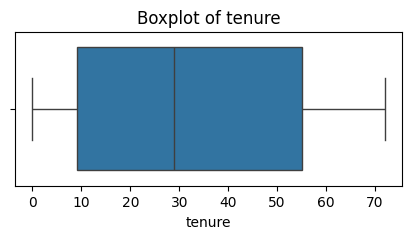

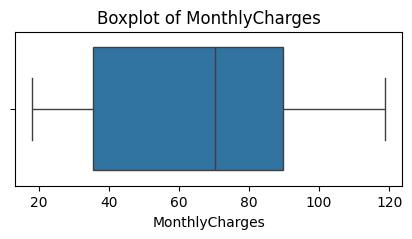

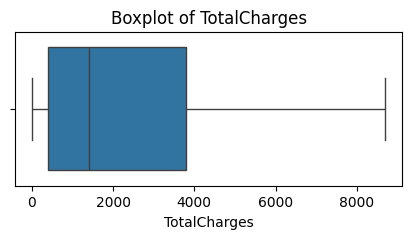

In [19]:
# List of columns to create boxplots for
columns_to_plot = ['tenure', 'MonthlyCharges', 'TotalCharges']

for column in columns_to_plot:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


### Interpretation of the TotalCharges Boxplot

Given the following statistics:
- Q1 ≈ 150
- Median ≈ 1500
- Q3 ≈ 4000
- No outliers


- **Most customers spend relatively little**:
   - **25% of customers** have `TotalCharges` ≤ 150. This means that a quarter of the customers have very low total charges.
   - **Half of the customers** have `TotalCharges` at or below 1500. This indicates that the median customer spends 1500 or less.

- **There’s a long right tail**:
   - **75% of customers** spend ≤ 4000. This means that three-quarters of the customers have total charges of 4000 or less.
   - The distance from the median (1500) up to Q3 (4000) is 2500, whereas the distance from Q1 (150) up to the median is only 1350. This asymmetry indicates that a smaller group of customers rack up much higher charges than the bulk of the customer base.

- **No extreme outliers**:
   - All data points lie within 1.5 × IQR of the quartiles, so there are no “statistical” outliers flagged on the plot. This means that while there is a long right tail, the data points are not extreme enough to be considered outliers.

### Business Takeaway:

- **The majority of customers are low-spend**: Most customers have relatively low total charges, which suggests that the bulk of the customer base is cost-conscious or has lower usage.
- **A minority of customers drive much of the high revenue**: A smaller group of customers is responsible for a significant portion of the total charges. These high spenders could be targeted for premium offers, loyalty rewards, or tailored retention strategies to maximize their value to the business.


##2.3 Bivariate & Multivariate Analysis

### Correlation matrix (heatmap)


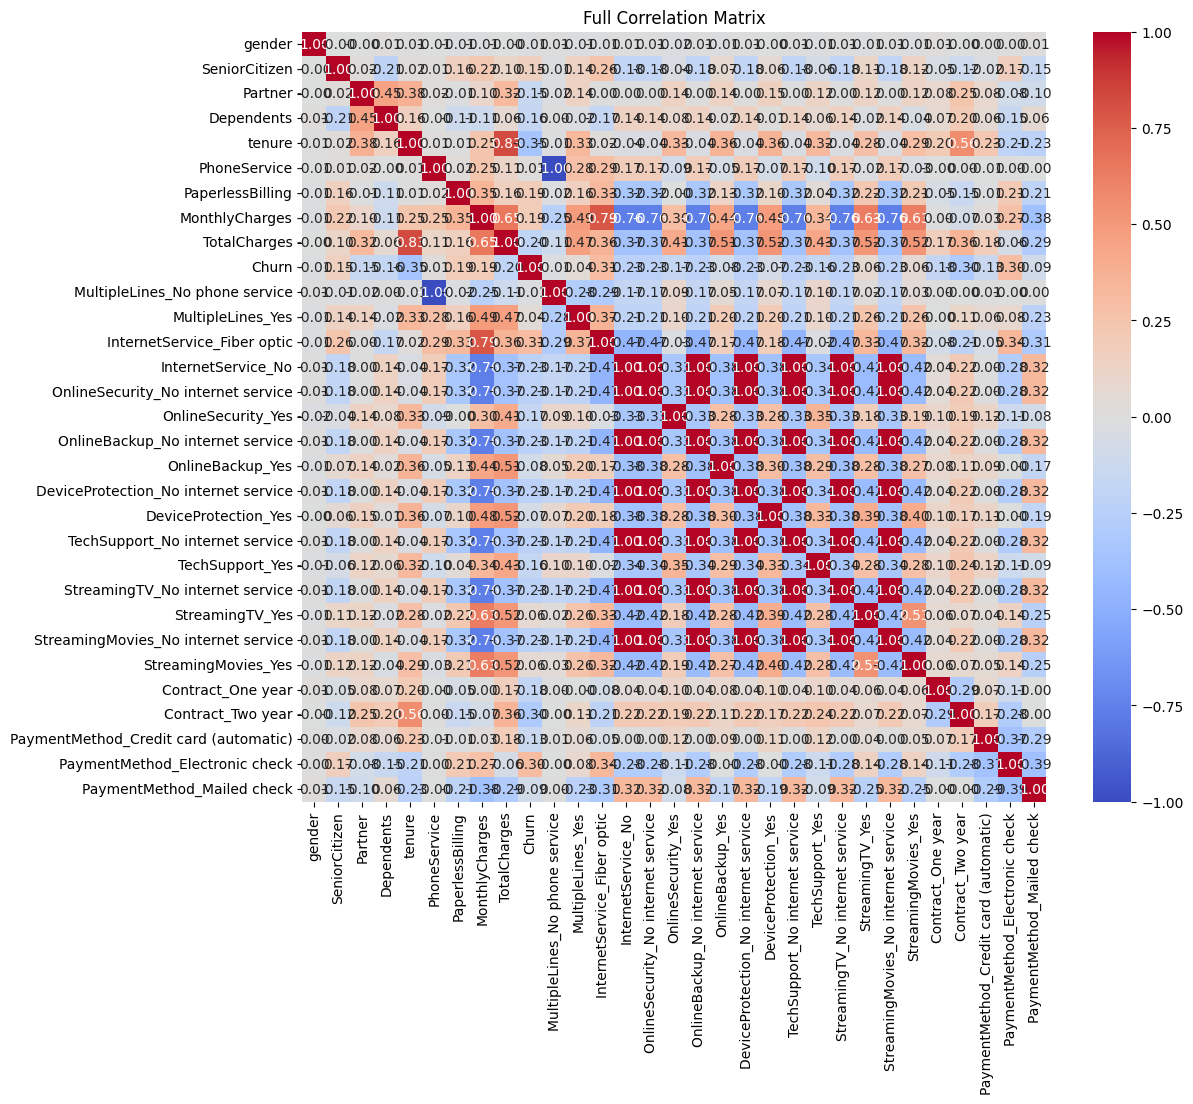

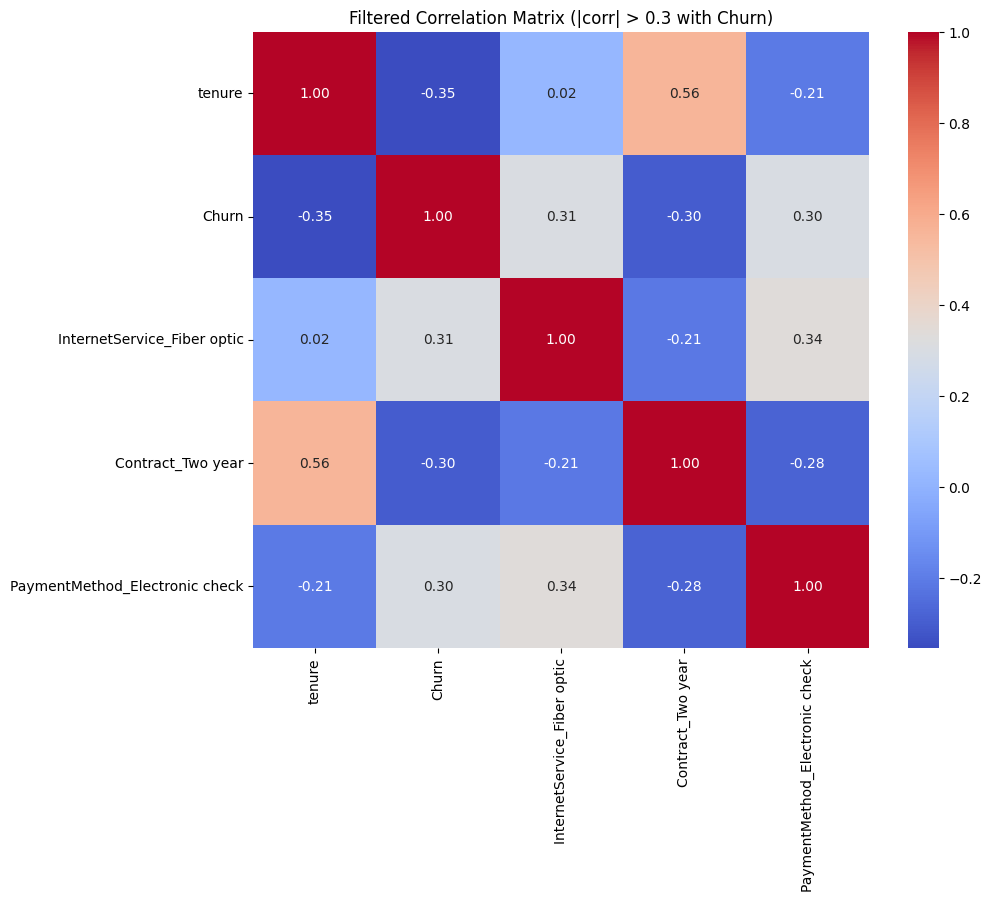

In [20]:
# 1) Compute full correlation matrix
corr = df.corr()

# 2) Full heatmap (optional)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Full Correlation Matrix")
plt.show()

# 3) Filter features based on correlation with the target variable
threshold = 0.3
filtered_features = corr['Churn'].abs() > threshold
filtered_features = corr.loc[filtered_features, 'Churn'].index.tolist()

# 4) Filtered heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr.loc[filtered_features, filtered_features],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title('Filtered Correlation Matrix (|corr| > 0.3 with Churn)')
plt.show()


In [21]:
print(filtered_features)

['tenure', 'Churn', 'InternetService_Fiber optic', 'Contract_Two year', 'PaymentMethod_Electronic check']


### Interpretation

The following features have an **absolute correlation greater than 0.3** with the target variable **"Churn"**:

- **tenure**
- **InternetService_Fiber optic**
- **Contract_Two year**
- **PaymentMethod_Electronic check**

### Explanation of Each Feature

### 📊 Tenure
- **Description**: Refers to the length of time a customer has been with the service provider.
- **Impact**: A longer tenure may correlate with lower churn rates, as customers who have been with a service for a longer time may be more satisfied.

### 🌐 InternetService_Fiber optic
- **Description**: Indicates whether the customer uses fiber optic internet service.
- **Impact**: Customers using fiber optic services may have different satisfaction levels compared to those using other types of internet services, potentially affecting their likelihood to churn.

### 📅 Contract_Two year
- **Description**: Indicates whether the customer is on a two-year contract.
- **Impact**: Customers on longer contracts may be less likely to churn, as they are committed for a longer period.

### 💳 PaymentMethod_Electronic check
- **Description**: Indicates if the customer uses electronic checks as their payment method.
- **Impact**: Different payment methods can influence customer satisfaction and retention, potentially affecting churn rates.

These features can be valuable for building predictive models to understand and reduce customer churn.


### Scatterplots of target vs. top continuous features

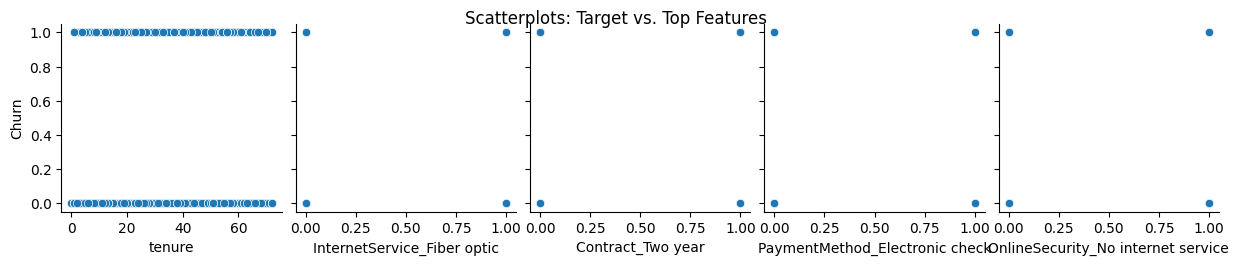

In [22]:
top_feats = corr['Churn'].abs().sort_values(ascending=False).head(6).index.drop('Churn')
sns.pairplot(df, x_vars=list(top_feats), y_vars="Churn", kind="scatter", diag_kind=None)
plt.suptitle("Scatterplots: Target vs. Top Features", y=1.02)
plt.show()


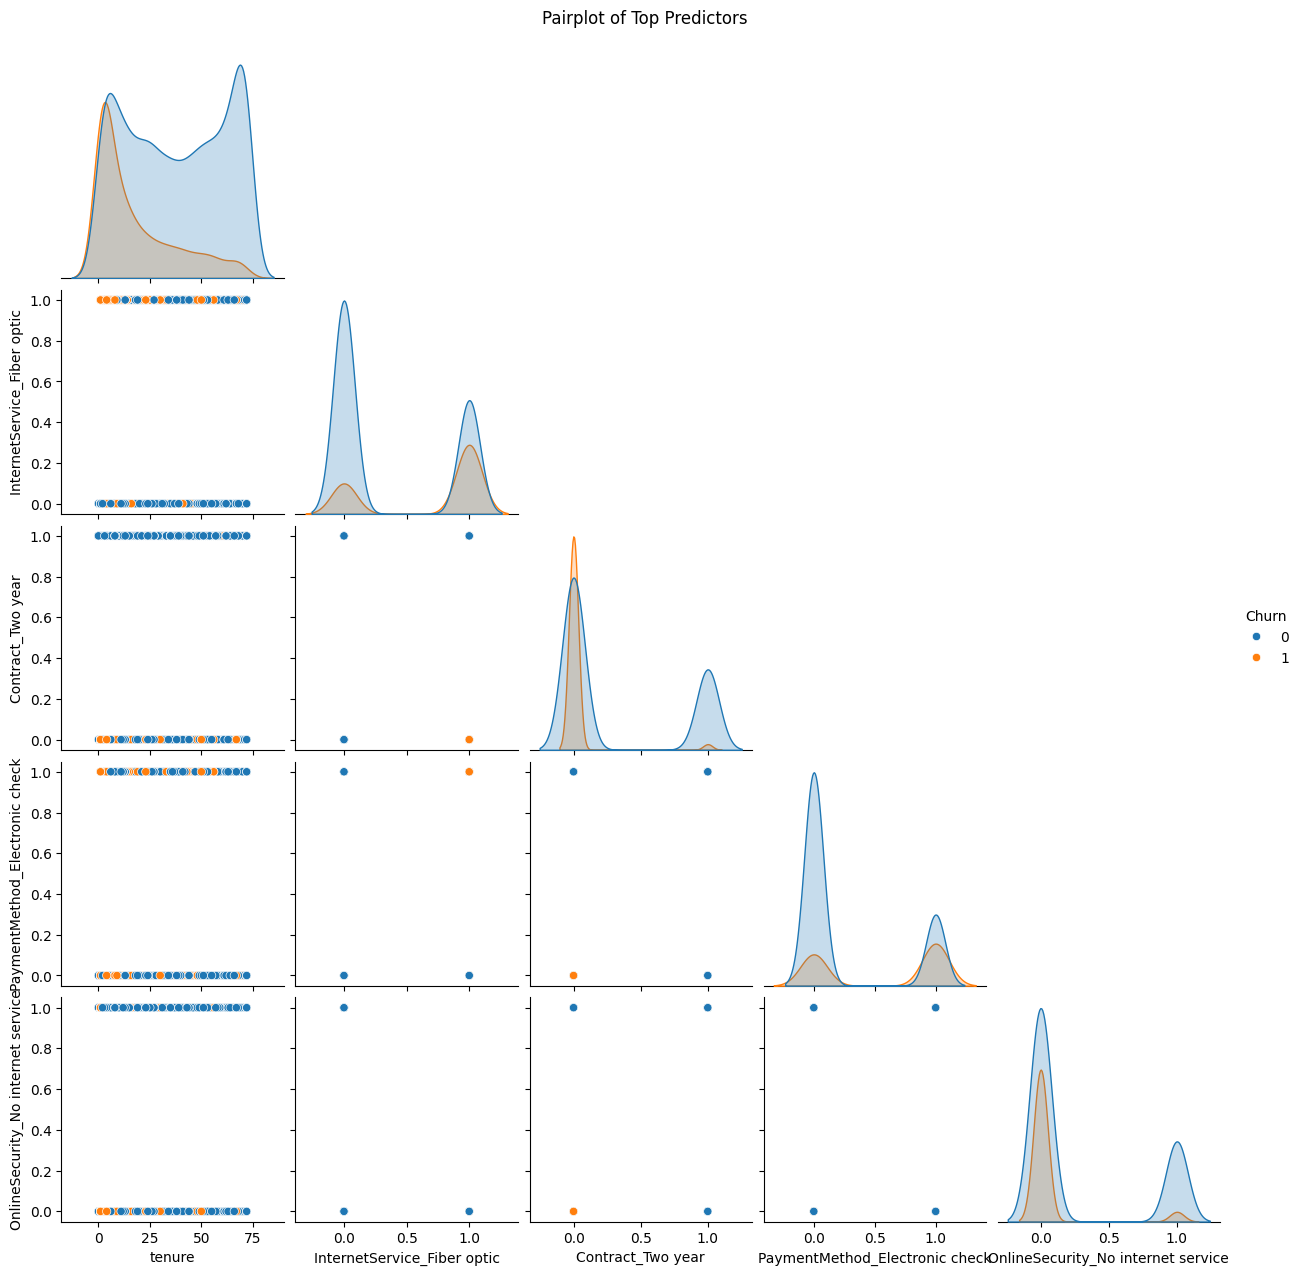

In [ ]:
sns.pairplot(df[list(top_feats) + ['Churn']], hue='Churn', vars=top_feats, corner=True)
plt.suptitle("Pairplot of Top Predictors", y=1.02)
plt.show()


### 2.4 Automated Profiling (optional)

```python

# pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_file("profile_report.html")

# Sweetviz
import sweetviz as sv
report = sv.analyze(df, target_feat='Churn')
report.show_html("sweetviz_report.html")

# D-Tale
import dtale
d = dtale.show(df)
d.open_browser()
```

# 3. Feature Selection & Compression

## 3.1 Recursive Feature Elimination (RFE) with Logistic Regression

RFE is a powerful feature selection technique used to identify the most important features in a dataset

### RFE explained:

RFE operates by recursively removing the least important features based on the model's performance:

1. RFE starts by training a model (e.g., logistic regression) on the entire set of features.
2. After training, it ranks the features based on their importance, which is typically determined by the model's coefficients or feature importances.
3. The least important feature(s) are removed from the dataset.

Steps 1-3 are repeated until the desired number of features is reached.



In [27]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


In [29]:
# Assuming df is your DataFrame
X = df.drop(columns="Churn")  # Features
y = df["Churn"]                # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Initialize and Fit RFE

In [30]:
# Initialize the Logistic Regression model
lr = LogisticRegression(max_iter=1000, solver='liblinear')

# Select top 10 features (adjust n_features_to_select as needed)
rfe = RFE(estimator=lr, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_].tolist()
print("RFE Selected Features:", selected_features)


RFE Selected Features: ['PhoneService', 'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingMovies_No internet service', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Electronic check']


### Evaluate the model (Optional)

In [31]:
# Fit the model with selected features
lr.fit(X_train[selected_features], y_train)

# You can then evaluate the model on the test set if needed
accuracy = lr.score(X_test[selected_features], y_test)
print("Model Accuracy with Selected Features:", accuracy)


Model Accuracy with Selected Features: 0.7991483321504613



## Interpretation of RFE Results


### 1. **Selected Features**
The output of RFE includes the features that were selected as the most important:

- **PhoneService**
- **InternetService_Fiber optic**
- **OnlineSecurity_Yes**
- **OnlineBackup_Yes**
- **TechSupport_No internet service**
- **TechSupport_Yes**
- **StreamingMovies_No internet service**
- **Contract_One year**
- **Contract_Two year**
- **PaymentMethod_Electronic check**

## Interpretation of Selected Features

### 1. **PhoneService**
This feature indicates whether a customer has a phone service. Its selection suggests that having or not having phone service is a significant factor in predicting customer churn. It may imply that customers without phone service are more likely to churn.

### 2. **InternetService_Fiber optic**
The presence of fiber optic internet service is a critical feature. This suggests that customers with fiber optic service may have different churn behaviors compared to those with other types of internet service. It could indicate that higher-quality service leads to lower churn rates.

### 3. **OnlineSecurity_Yes**
This feature indicates whether a customer has opted for online security services. Its selection implies that customers who invest in additional security features are less likely to churn, possibly due to increased satisfaction or perceived value.

### 4. **OnlineBackup_Yes**
Similar to online security, having online backup services is associated with lower churn. This suggests that customers who utilize backup services may feel more secure and satisfied with their service, reducing the likelihood of leaving.

### 5. **TechSupport_No internet service**
This feature indicates customers who do not have access to tech support due to not having internet service. Its selection may suggest that the lack of support contributes to dissatisfaction and increases the likelihood of churn.

### 6. **TechSupport_Yes**
Conversely, having tech support is also a selected feature. This indicates that customers who have access to tech support are less likely to churn, highlighting the importance of customer service in retaining clients.

### 7. **StreamingMovies_No internet service**
This feature indicates that customers without internet service cannot access streaming movies. Its selection suggests that the inability to access entertainment options may lead to higher churn rates, as customers may seek alternatives.

### 8. **Contract_One year**
The selection of a one-year contract indicates that customers with this type of commitment may have different churn behaviors. It could imply that customers with shorter contracts are more likely to churn, possibly due to the flexibility to leave.

### 9. **Contract_Two year**
Similarly, a two-year contract suggests that customers who commit for a longer duration may be less likely to churn. This could indicate that longer contracts foster loyalty or satisfaction.

### 10. **PaymentMethod_Electronic check**
The method of payment can also influence churn. Customers who pay via electronic check may have different behaviors compared to those using other payment methods. Its selection suggests that this payment method is associated with lower churn rates.

## Feature Importance
The features that remain after RFE are those that contribute the most to the model's predictive power. This can help in:
- **Reducing Overfitting**: By eliminating irrelevant or redundant features, the model may generalize better to unseen data.
- **Improving Interpretability**: Fewer features make the model easier to understand and interpret.


The selected features can provide insights into the relationships between the features and the target variable. For instance, if `MonthlyCharges` and `Contract_Two year` are selected, it may suggest that these factors significantly influence customer churn.

## Further Analysis
After identifying the important features, you can conduct further analysis, such as:
- **Visualizations**: Create plots to visualize the relationships between selected features and the target variable.
- **Model Comparison**: Compare the performance of models trained with all features versus those trained with selected features.

In summary, RFE is a valuable tool for feature selection, helping to streamline models and enhance their performance. By focusing on the most relevant features, you can build more efficient and interpretable models.

## 3.2 Dimensionality Reduction (PCA) to retain 90% variance

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# PCA
pca = PCA(n_components=0.90, random_state=42)  # 90% variance
X_pca = pca.fit_transform(X_scaled)
print(f"Number of components to retain 90% variance: {pca.n_components_}")


Number of components to retain 90% variance: 15


### 3D Visualization PCA

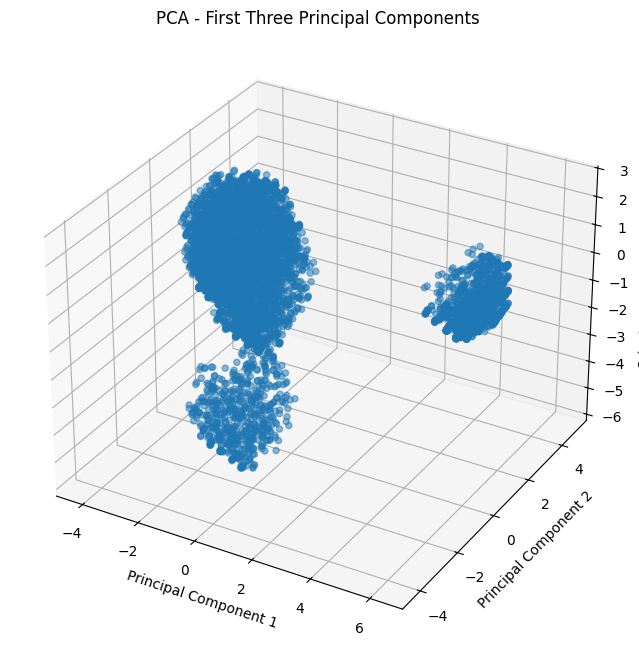

In [34]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.5)
ax.set_title('PCA - First Three Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()


### Interpretion of PCA - Variance Explained:

- **Components**: Each of the 15 components represents a linear combination of the original features. They capture the underlying structure of the data.

- **Variance**: The fact that these 15 components explain 90% of the variance means that they collectively account for a significant portion of the information in your original dataset. This is beneficial as it reduces dimensionality while retaining most of the data's variability.

### Next step:

- **Further Dimensionality Reduction**:
   - If you find that 15 components are still too many for your model, you can experiment with retaining fewer components while still capturing a significant amount of variance (e.g., 80%).



## 📝 Conclusion

In this notebook, we have successfully navigated through a comprehensive data analysis pipeline using the **Telco Customer Churn Dataset**. Our primary objective was to gain a thorough understanding of the dataset and identify the most relevant features for building an effective machine learning model.

### Key Steps and Insights:

1. **Data Ingestion & Initial Cleaning**: We began by loading the dataset and performing essential cleaning tasks. This included handling missing values, removing duplicates, and addressing inconsistencies, which are crucial for ensuring data quality and reliability.

2. **Exploratory Data Analysis (EDA)**: Through EDA, we explored the dataset's structure and distributions, uncovering valuable insights into customer demographics, account information, and service usage. This step allowed us to visualize relationships between variables and identify potential patterns that could influence customer churn.

3. **Feature Selection and Dimensionality Reduction**: We employed Recursive Feature Elimination (RFE) to select the most relevant features, followed by Principal Component Analysis (PCA) to reduce dimensionality while retaining a significant amount of variance. This not only streamlined our dataset but also enhanced the performance of our machine learning models by focusing on the most impactful features.

### Final Thoughts:
The structured approach taken in this Data Analysis ensures that we have a solid foundation for building a performant ML model.

By understanding the data thoroughly and selecting the most relevant features, we are well-positioned to predict customer churn effectively. Future steps could involve model training, evaluation, and fine-tuning to further enhance predictive accuracy.

This Data Analysis highlights the importance of a systematic data analysis pipeline in deriving actionable insights and making informed decisions in the realm of customer retention strategies for telecom providers.